In [10]:
import numpy as np
a = np.array([1,2,3])
b = np.array([4,5,6])
# c = np.sum(a*b)
c = np.dot(a,b)
c

32

In [13]:
a = np.array([[1,2,3], [4,5,6], [7,8,9]])
b = np.array([4,5,6])
c = np.dot(a,b)
c

array([ 32,  77, 122])

In [15]:
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[4,5], [6,7], [8,9]])
c = np.dot(a,b)
c

array([[ 40,  46],
       [ 94, 109]])

In [24]:
a = np.array([1,2,3])
print(a.T)
b = a.copy()
b.reshape(-1,1)

[1 2 3]


array([[1],
       [2],
       [3]])

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [28]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [34]:
print(x_train.shape)
print(y_train.shape)

(364, 30)
(364,)


In [35]:
a = x_train[:,1]
print(a.shape)

(364,)


In [36]:
err = a - y_train
print(err.shape)

(364,)


In [61]:
class SingleLayer:
    def __init__(self, learning_rate = 0.01,l1=0,l2=0):  ##
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []        
        self.lr = learning_rate    
        self.val_losses = []
        self.l1=l1
        self.l2=l2
        
    def forpass(self,x):
        #z = np.sum(x * self.w)+ self.b
        z = np.dot(x, self.w) + self.b
        return z
    
    def activation(self,z):
        z = np.clip(z,-100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def backprop(self, x, err):
        #w_grad = x * err
        #b_grad = 1 * err
        #mse
        m = len(x)
        w_grad = np.dot(x.T,err) /m
        b_grad = np.sum(err)/m
        return w_grad, b_grad
    
    def fit(self,x,y,epochs=100,x_val=None, y_val=None):
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1)
        m = len(x)
        self.w = np.ones((x.shape[1],1))
        
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            #loss = 0
            #indexes = np.random.permutation(np.arange(len(x)))
            #for i in indexes:
            #z = self.forpass(x[i])
            z = self.forpass(x)
            a = self.activation(z)
            err = a - y
            #w_grad,b_grad = self.backprop(x[i],err)
            w_grad,b_grad = self.backprop(x,err)


            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= self.lr * w_grad           ##        
            self.b -= self.lr * b_grad

            self.w_history.append(self.w.copy())  
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))

            self.losses.append((loss + self.reg_loss())/m)  ##
            self.update_val_loss(x_val,y_val)
            
    def reg_loss(self):  
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)  
    
    def update_val_loss(self,x_val,y_val):
        #if x_val is None:
        #    return
        #val_loss = 0
        #for i in range(len(x_val)):
        #    z = self.forpass(x_val[i])
            z = self.forpass(x_val)
            a = self.activation(z)
            a = np.clip(a,1e-10, 1-1e-10)
            val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
            self.val_losses.append((val_loss+ self.reg_loss())/len(y_val))
            
    def predict(self,x):
        #z = [self.forpass(x_i) for x_i in x]
        z = self.forpass(x)
        return z > 0
    
    def score(self,x,y):
        return np.mean(self.predict(x) == y.reshape(-1,1))

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [66]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

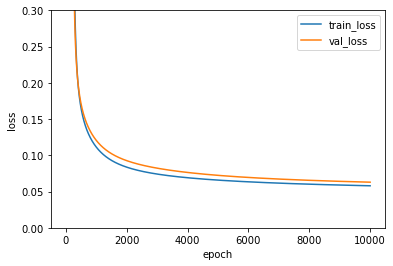

In [67]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

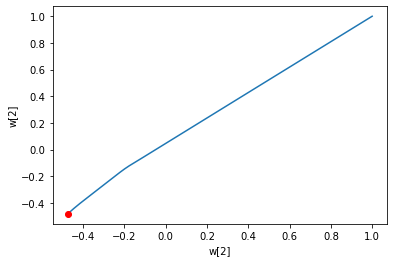

In [70]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[2]')
plt.show()

In [71]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         
        self.w1 = None             
        self.b1 = None             
        self.w2 = None             
        self.b2 = None             
        self.a1 = None             
        self.losses = []           
        self.val_losses = []       
        self.lr = learning_rate    
        self.l1 = l1               
        self.l2 = l2               

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        
        self.a1 = self.activation(z1)            
        z2 = np.dot(self.a1, self.w2) + self.b2  
        return z2

    def backprop(self, x, err):
        m = len(x)       
        
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  
        self.b1 = np.zeros(self.units)               
        self.w2 = np.ones((self.units, 1))           
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    
        self.init_weights(x.shape[1]) 
        
        for i in range(epochs):
            a = self.training(x, y, m)
            
            a = np.clip(a, 1e-10, 1-1e-10)
            
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       
        a = self.activation(z)    
        err = -(y - a)            
        
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [72]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, 
               x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

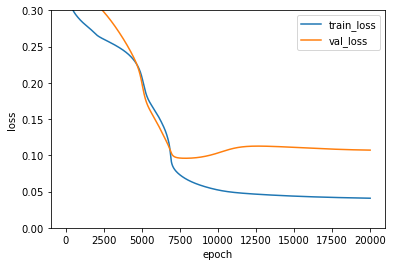

In [73]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [74]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

In [75]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train,
                    x_val=x_val_scaled, y_val=y_val, epochs=500)

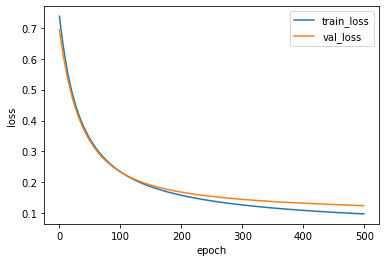

In [76]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [1]:
# 층화추출법
import seaborn as sns
iris = sns.load_dataset('iris')
x = iris.iloc[:, :-1]
y = iris.iloc[:, -1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105,), (45,))

In [4]:
y_test.value_counts()

virginica     17
setosa        16
versicolor    12
Name: species, dtype: int64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [6]:
y.value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

In [7]:
y_test.value_counts()

virginica     15
setosa        15
versicolor    15
Name: species, dtype: int64

In [12]:
import numpy as np
temp = np.array([[2.20, 1.39, 0.85], [0.00, -1.39, -2.20]])
exp_temp = np.exp(temp)
ret = exp_temp/np.sum(exp_temp, axis=1).reshape(-1,1)
ret

array([[0.5868206 , 0.26105188, 0.15212752],
       [0.73535983, 0.18315997, 0.08148019]])

In [36]:
# import numpy as np
# class MultiClassNetwork:
#     def __init__(self, units=10, batch_size=32, learning_rate=0.01, l1=0, l2=0):
#         self.units = units
#         self.batch_size = batch_size
#         self.w1 = None
#         self.b1 = None
#         self.w2 = None
#         self.b2 = None
#         self.losses = []
#         self.val_losses = []
#         self.lr = learning_rate
#         self.l1 = l1
#         self.l2 = l2
    
#     def forpass(self, x):
#         z1 = np.dot(x, self.w1) + self.b1
#         self.a1 = self.sigmoid(z1)
#         z2 = np.dot(self.a1, self.w2) + self.b2
#         return z2
        
#     def backprop(self, x, err):
#         m = len(x)
        
#         w2_grad = np.dot(self.a1.T, err) / m
#         b2_grad = np.sum(err) / m
        
#         err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1- self.a1)        
#         w1_grad = np.dot(x.T, err_to_hidden)
#         b1_grad = np.sum(err_to_hidden, axis=0) / m
#         return w1_grad, b1_grad, w2_grad, b2_grad
    
#     def sigmoid(self, z):
#         z = np.clip(z, -100, None)
#         a = 1 / (1 + np.exp(-z))
#         return a
    
#     def sortmax(self, z):
#         z = np.clip(z, -100, None)
#         exp_z = np.exp(z)
#         return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)
    
#     def init_weights(self, n_features, n_classes):
#         self.w1 = np.random.normal(0,1, (n_features, self.units))
#         self.b1 = np.zeros(self.units)
#         self.w2 = np.random.normal(0,1, (self.units, n_classes))
#         self.b2 = np.zeros(n_classes)
        
#     def fit(self, x, y, epochs=100, x_val=None, y_val=None):
#         np.random.seed(42)
#         self.init_weights(x.shape[1], y.shape[1])
        
#         for i in range(epochs):
#             loss = 0
#             print('.', end=' ')
#             for x_batch, y_batch in self.gen_batch(x, y):
#                 a = self.training(x_batch, y_batch)
#                 a = np.clip(a, 1e-10, 1-1e-10)
#                 loss += np.sum(-y_batch*np.log(a))
#             self.losses.append((loss + self.reg_loss()) / len(x))
#             self.update_val_loss(x_val, y_val)
            
#     def gen_batch(self, x, y):
#         length = len(x)
#         bins = length // self.batch_size
#         if length % self.batch_size:
#             bins += 1
#         indexes = np.random.permutation(np.arange(len(x)))
#         x = x[indexes]
#         y = y[indexes]
#         for i in range(bins):
#             start = self.batch_size * i
#             end = self.batch_size * (i + 1)
#             yield x[start:end], y[start:end]
            
#     def training(self, x, y):
#         m = len(x)
#         z = self.forpass(x)
#         a = self.softmax(z)
#         err = (a - y)
#         w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
#         w1_grad += (self.l1 * np.sign(self.w1)+ self.l2 * self.w1) / m
#         w2_grad += (self.l1 * np.sign(self.w2)+ self.l2 * self.w2) / m
        
#         self.w1 -= self.lr * w1_grad
#         self.w2 -= self.lr * w2_grad
        
#     def predict(self, x):
#         z = self.fopass(x)
#         return np.argmax(z, axis=1)
    
#     def score(self, x, y):
#         return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
#     def reg_loss(self):
#         return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum()self.w2**2)
    
#     def update_val_loss(self, x_val, y_val):
#         z = self.forpass(x_val)
#         a = self.softmax(z)
#         a = np.clip(a, 1e-10, 1-1e-10)
#         val_loss = np.sum(-y_val*np.log(a))
#         self.val_losses.append((val_loss. self.reg_loss()) / len(y_val))
        
import numpy as np
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [37]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [38]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [39]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


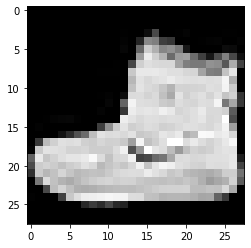

In [40]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [42]:
x_train = x_train/255
x_val = x_val/255

In [43]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [46]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
y_train_encoded.shape

(48000, 10)

........................................

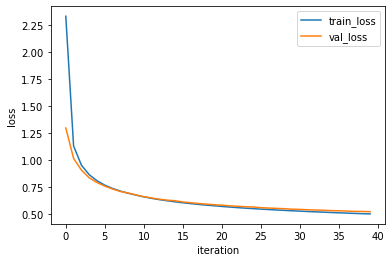

In [47]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [50]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [51]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 2s 1ms/step - loss: 1.3850 - accuracy: 0.6352 - val_loss: 0.9602 - val_accuracy: 0.7326
Epoch 2/40
1500/1500 [==============================] - 1s 889us/step - loss: 0.8427 - accuracy: 0.7425 - val_loss: 0.7514 - val_accuracy: 0.7614
Epoch 3/40
1500/1500 [==============================] - 1s 888us/step - loss: 0.7132 - accuracy: 0.7627 - val_loss: 0.6663 - val_accuracy: 0.7808
Epoch 4/40
1500/1500 [==============================] - 1s 851us/step - loss: 0.6494 - accuracy: 0.7771 - val_loss: 0.6152 - val_accuracy: 0.7900
Epoch 5/40
1500/1500 [==============================] - 1s 875us/step - loss: 0.6084 - accuracy: 0.7904 - val_loss: 0.5794 - val_accuracy: 0.8008
Epoch 6/40
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5786 - accuracy: 0.8001 - val_loss: 0.5539 - val_accuracy: 0.8098
Epoch 7/40
1500/1500 [==============================] - 1s 915us/step - loss: 0.5556 - accuracy: 0.8081 - val_loss: 0.5326 - val

In [53]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


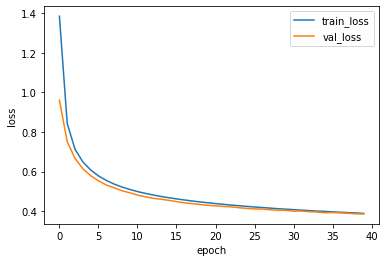

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [55]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8631666898727417
